# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [2]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

    # YOUR CODE HERE

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    threshold = 0.5
    for batch, (X, y) in enumerate(dataloader):
        #y = y.long()
        y = y.unsqueeze(1)
        # Compute predictions and loss
        predicted_probabilities = model(X)
        predictions = (predicted_probabilities > threshold)
        
        #pred = model(X)
        loss = loss_fn(predicted_probabilities, y)
        
        train_loss += loss.item()
        correct += (predictions == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    threshold = 0.5
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #y = y.long()
            y = y.unsqueeze(1)
            predicted_probabilities = model(X)
            predictions = (predicted_probabilities > threshold)
            test_loss += loss_fn(predicted_probabilities, y).item()
            correct += (predictions == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [4]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # Preporocessing
    f_columns_to_drop = ['label', 'filename'] #These columns are dropped to get only the features
    X_train_notscaled, y_train, X_test_notscaled, y_test = split_dataset(df, columns_to_drop = f_columns_to_drop, test_size = 0.3, random_state = 0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train_notscaled, X_test_notscaled) # This step performs the actual scalling 
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [5]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]



def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_dataloader, test_dataloader

batch_size = 256
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [6]:
# YOUR CODE HERE
from common_utils import EarlyStopper

model_no_features = 77
model_no_hidden = 128
model_no_labels = 1
model = MLP(no_features = model_no_features, no_hidden = model_no_hidden, no_labels = model_no_labels)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
loss_fn = nn.BCELoss()
epochs = 100
es_patience = 3
earlyStop = EarlyStopper(patience = es_patience)

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [7]:
# YOUR CODE HERE
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if earlyStop.early_stop(test_loss): 
        print("Done!")
        break

loss: 0.697151  [  256/ 8439]
Train Error: 
 Accuracy: 53.5%, Avg loss: 0.687970 

Test Error: 
 Accuracy: 56.4%, Avg loss: 0.684445 

Epoch 1: Train_accuracy: 53.48%, Train_loss: 0.687970, Test_accuracy: 56.38%, Test_loss: 0.684445
loss: 0.665102  [  256/ 8439]
Train Error: 
 Accuracy: 58.3%, Avg loss: 0.674815 

Test Error: 
 Accuracy: 57.7%, Avg loss: 0.676691 

Epoch 2: Train_accuracy: 58.32%, Train_loss: 0.674815, Test_accuracy: 57.66%, Test_loss: 0.676691
loss: 0.665106  [  256/ 8439]
Train Error: 
 Accuracy: 60.8%, Avg loss: 0.657509 

Test Error: 
 Accuracy: 60.3%, Avg loss: 0.656677 

Epoch 3: Train_accuracy: 60.84%, Train_loss: 0.657509, Test_accuracy: 60.34%, Test_loss: 0.656677
loss: 0.636162  [  256/ 8439]
Train Error: 
 Accuracy: 62.2%, Avg loss: 0.648382 

Test Error: 
 Accuracy: 61.9%, Avg loss: 0.660925 

Epoch 4: Train_accuracy: 62.21%, Train_loss: 0.648382, Test_accuracy: 61.86%, Test_loss: 0.660925
loss: 0.668626  [  256/ 8439]
Train Error: 
 Accuracy: 64.1%, Avg lo

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


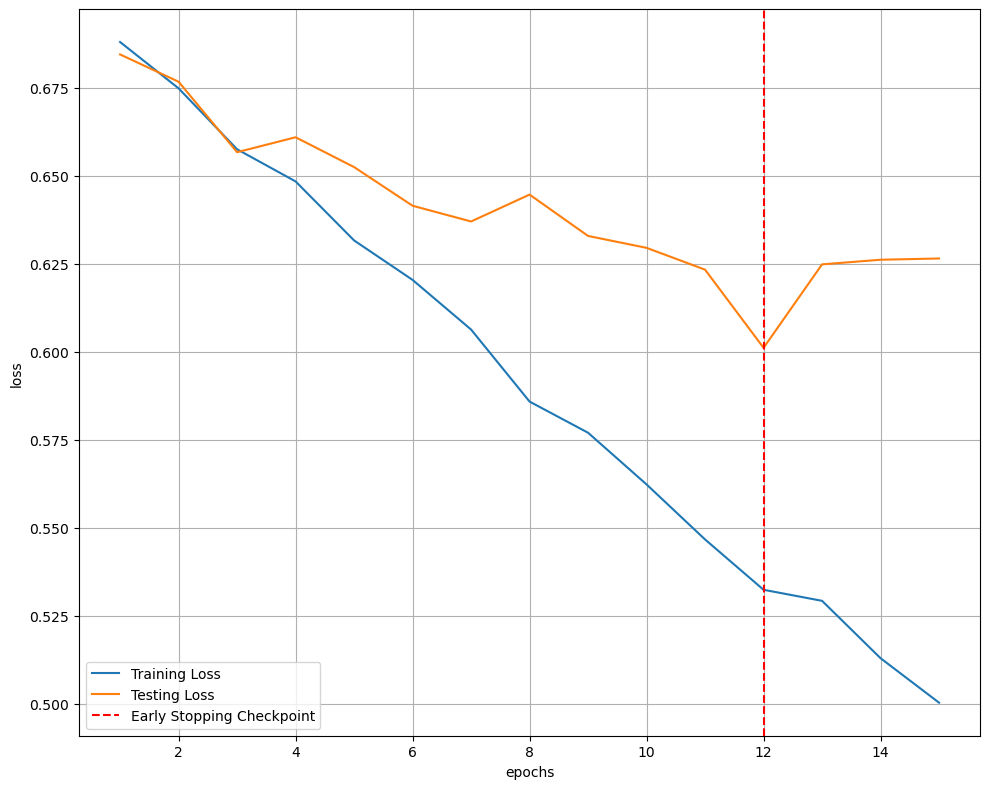

In [8]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Testing Loss')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

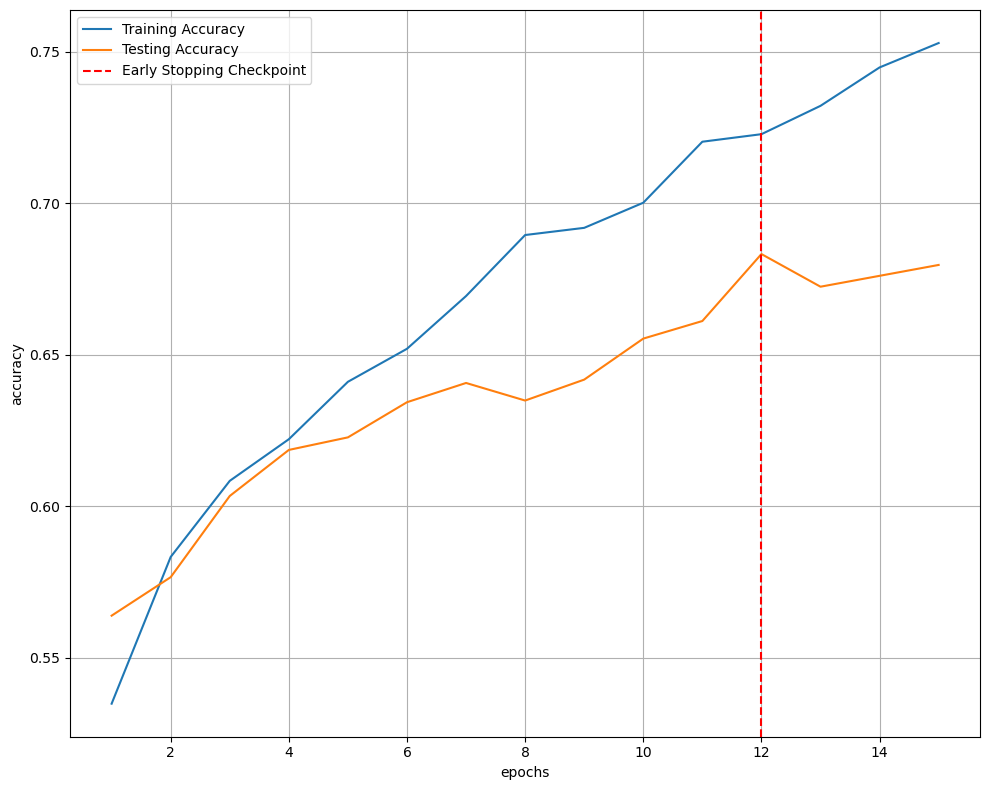

In [9]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_correct)+1),tr_correct, label='Training Accuracy')
plt.plot(range(1,len(te_correct)+1),te_correct,label='Testing Accuracy')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

2. Comment on line plots.

In [1]:
# YOUR CODE HERE
answer = "As the model is trained on more epochs the training accuracy increases and training loss reduces. However, the testing accuracy decreases and testing loss increases, indicating that with more epochs the model is being overtrained and eventually would not be able to perform well on unseen data. Hence, we enforced early stopping as seen from the graph"